# SVD Basis

## Preparation

In [1]:
from utility import *
from grid import *
from scipy import integrate
from scipy.interpolate import UnivariateSpline
import numpy.linalg as linalg
import basis

In [2]:
Para=param()
TauGrid = BuildTauGrid(Para, TauGridSize)
MomGrid = BuildMomGrid(Para.MaxExtMom, MomGridSize)

Rs=1.0, kF=1.91915829268, EF=3.68316855235, Beta=10.8602143593


In [3]:
W2T, T2W = basis.BuildBasis(TauGrid, Para.Beta, 60, "Fermi")

## Load Sigma Data

In [4]:
folder = "./Beta{0}_rs{1}_lambda{2}/".format(
    int(Para.Beta*Para.EF), Para.Rs, Para.Mass2)

filename = "sigma_pid[0-9]+.dat"

shape = (Para.Order+1, MomGridSize, TauGridSize)

Data, Norm, Step = LoadFile(folder, filename, shape)

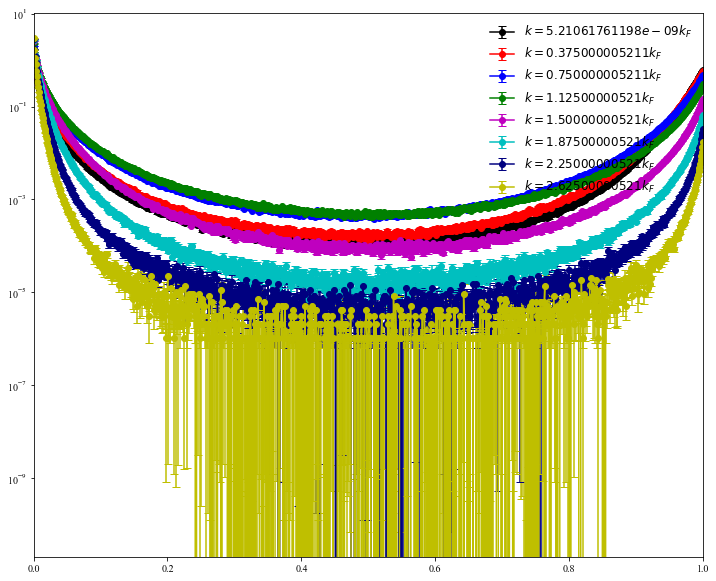

In [5]:
fig, ax = plt.subplots(figsize=(12, 10))
N = 8
o = 2
for i in range(N):
    q = i*MomGridSize/N
    Avg, Err = Estimate(Data, Norm)
    ax.errorbar(TauGrid/Para.Beta, -Avg[o, q, :], yerr=Err[o, q, :], fmt='o-',
                capthick=1, capsize=4, color=ColorList[i], label="$k={0}k_F$".format(MomGrid[q]/Para.kF))
    
ax.set_yscale("log")
ax.set_xlim([TauGrid[0]/Para.Beta, TauGrid[-1]/Para.Beta])
plt.legend(loc=1, frameon=False, fontsize=size)
plt.show()

## Basis Construction

In [6]:
def FermiKernel(w, t, beta):
    x = beta*w/2
    y = 2*t/beta-1
    if x > 100:
        return np.exp(-x*(y+1.))
    if x < -100:
        return np.exp(x*(1.0-y))
    return np.exp(-x*y)/(2*np.cosh(x))

(1024,)


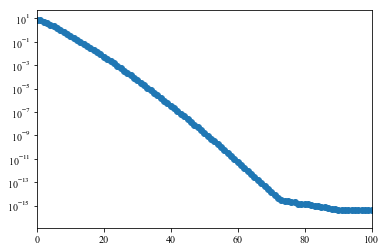

In [41]:
Nw = 1024
Wmax=100
w = np.linspace(-Wmax, Wmax, Nw)
Nt = len(TauGrid)
kMatrix = np.zeros([Nw, Nt])

for i in range(len(w)):
    kMatrix[i, :] = FermiKernel(w[i], TauGrid, Para.Beta)*2.0*Wmax/Nw

u, s, v = linalg.svd(kMatrix)
v_inv = linalg.inv(v)
u_inv=linalg.inv(u)
N=Nw
x=range(N)
y=s[:N]
print y.shape
plt.plot(x, y, 'o-')
plt.yscale('log')
plt.xlim([0.0, 100])
plt.show()

## Basis Fit

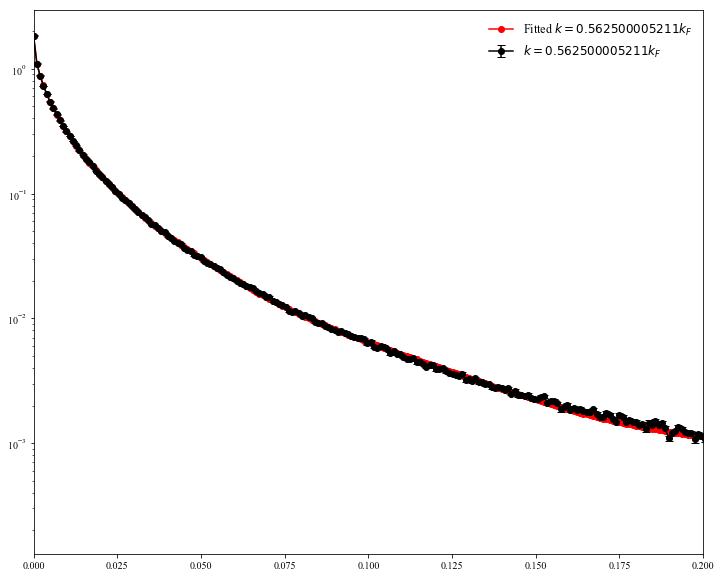

In [42]:
fig, ax = plt.subplots(figsize=(12, 10))
N = 8
o = 2
q=12
Nlim=30

SigmaT, Err = Estimate([d[o, q, :] for d in Data], Norm)

Elem=np.dot(SigmaT, v.T[:,:Nlim])
Fitted=np.dot(Elem, v[:Nlim,:])
    
ax.errorbar(TauGrid/Para.Beta, -SigmaT, yerr=Err, fmt='o-',
            capthick=1, capsize=4, color=ColorList[0], label="$k={0}k_F$".format(MomGrid[q]/Para.kF))
    
ax.plot(TauGrid/Para.Beta, -Fitted, 'o-'
            , color=ColorList[1], label="Fitted $k={0}k_F$".format(MomGrid[q]/Para.kF))
    
ax.set_yscale("log")
ax.set_xlim([0.0, 0.2])
#ax.set_ylim([0.0, 0.1])
#ax.set_xlim([TauGrid[0]/Para.Beta, TauGrid[-1]/Para.Beta])
plt.legend(loc=1, frameon=False, fontsize=size)
plt.show()

## Signular value versus Coefficient

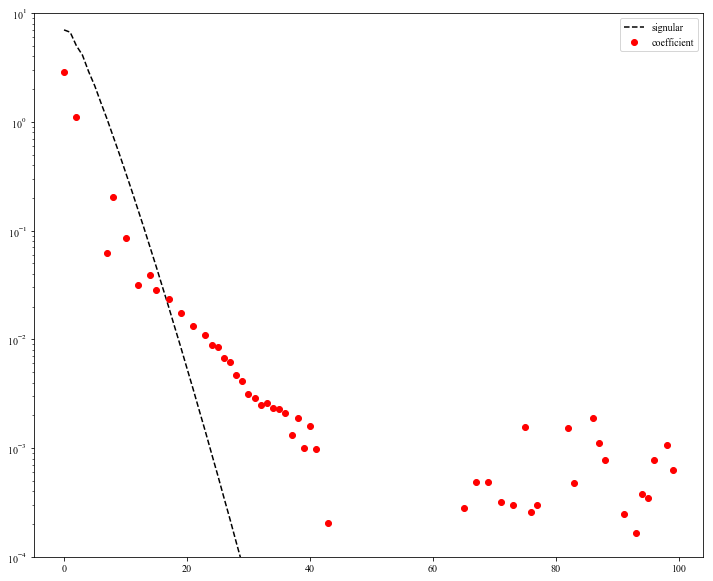

In [43]:
fig, ax = plt.subplots(figsize=(12, 10))

Nlim=100

SigmaT, Err = Estimate([d[o, q, :] for d in Data], Norm)

Elem=np.dot(SigmaT, v.T[:,:Nlim])
    
x=range(Nlim)
y=s[:Nlim]
plt.plot(x, y, 'k--', label="signular")
plt.plot(x, Elem, 'ro', label="coefficient")
plt.legend()
plt.yscale('log')
plt.ylim([1.e-4, 10])
plt.show()

## Specutral function

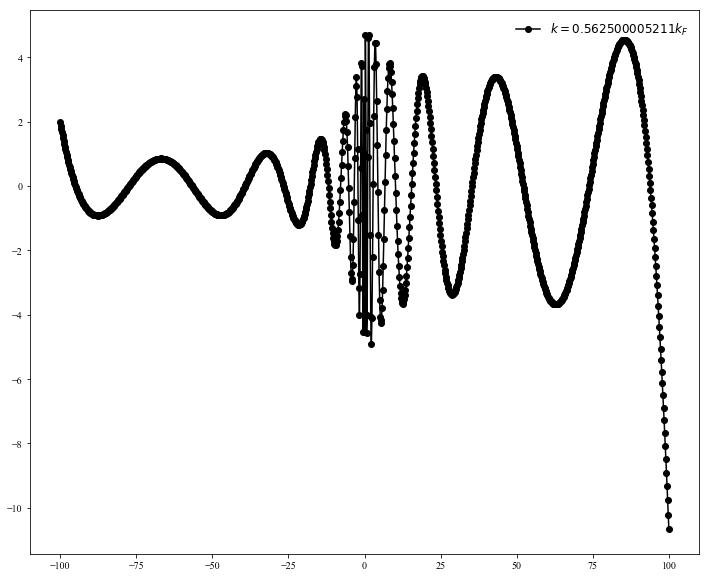

In [51]:
ss=np.zeros((Nt, Nw))
Nsvd=30
for i in range(Nsvd):
    ss[i, i]=1.0/s[i]

InvKernel=np.dot(np.dot(v.T, ss), u.T)
spectral=np.dot(SigmaT, InvKernel)

fig, ax = plt.subplots(figsize=(12, 10))

ax.plot(w, spectral, 'ko-', label="$k={0}k_F$".format(MomGrid[q]/Para.kF))
    
#ax.set_yscale("log")
#ax.set_xlim([0.0, 0.2])
#ax.set_ylim([0.0, 0.1])
#ax.set_xlim([TauGrid[0]/Para.Beta, TauGrid[-1]/Para.Beta])
plt.legend(loc=1, frameon=False, fontsize=size)
plt.show()

## Matsubara Frequency Basis

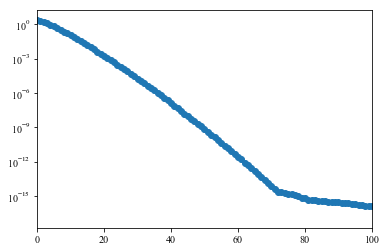

In [52]:
def FermiKernelMatFreq(w, wn, beta):
    return 1.0/(1j*wn-w)

WnMax=1024
Wn = (np.array(range(-WnMax, WnMax))*2.0+1.0)*np.pi/Para.Beta
Nwn=len(Wn)
MatFreqMatrix = np.zeros([Nw, len(Wn)], dtype=complex)

for i in range(len(w)):
    MatFreqMatrix[i, :] = FermiKernelMatFreq(w[i], Wn, Para.Beta)*2.0*Wmax/Nw

uw, sw, vw = linalg.svd(MatFreqMatrix)

x=range(Nw)
y=sw[:Nw]
#print Nw, len(s)
#print y.shape, len(x)
plt.plot(x, y, 'o-')
plt.yscale('log')
plt.xlim([0.0, 100])
plt.show()

## Matsubara Frequency Sigma

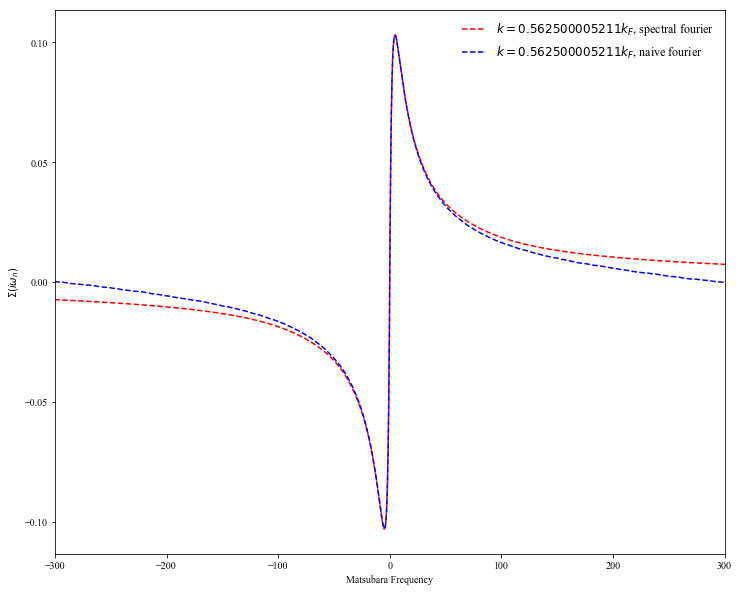

In [61]:
ssw=np.zeros((Nw, Nwn))
for i in range(Nsvd):
    ssw[i, i]=sw[i]

SigmaW=np.dot(np.dot(np.dot(spectral, uw), ssw), vw)

## Benchmark

SigmaW_ref=np.zeros_like(SigmaW)

for i, freq in enumerate(Wn):
    dw = SigmaT*np.exp(-1j*TauGrid*freq)
    SigmaW_ref[i] = integrate.trapz(dw, TauGrid)

fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(Wn, SigmaW.imag, 'r--',  label="$k={0}k_F$, spectral fourier".format(MomGrid[q]/Para.kF))  
ax.plot(Wn, SigmaW_ref.imag, 'b--', label="$k={0}k_F$, naive fourier".format(MomGrid[q]/Para.kF))  
#ax.set_yscale("log")
ax.set_xlim([-300, 300])
ax.set_xlabel("Matsubara Frequency")
ax.set_ylabel("$\Sigma(i\omega_n)$")
#ax.set_ylim([0.0, 0.1])
#ax.set_xlim([TauGrid[0]/Para.Beta, TauGrid[-1]/Para.Beta])
plt.legend(loc=1, frameon=False, fontsize=size)
plt.savefig("sigma.pdf")
plt.show()